# 영화 관객 예측
***


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

In [14]:
train = pd.read_csv("movies_train.csv")
test = pd.read_csv('movies_test.csv')
submission = pd.read_csv('submission.csv')

In [15]:
train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


In [16]:
test.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


In [17]:
submission.head(3)

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0


#### 배급사 전처리

In [18]:
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')

In [19]:
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [20]:
def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [21]:
train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

#### 장르별 영화 관객수 평균값으로 랭크 인코딩

In [22]:
train.groupby('genre').box_off_num.mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [23]:
train['genre_rank'] = train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
test['genre_rank'] = test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

#### 배급사별 영화 관객수 중위값 기준으로 배급사 랭크 인코딩

In [24]:
tr_nm_rank = train.groupby('distributor').box_off_num.median().reset_index(name = 'num_rank').sort_values(by = 'num_rank')
tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,2.0
15,고구마공작소,8.0
52,사람과사람들,42.0
97,위드시네마,46.0
19,나우콘텐츠,54.0
...,...,...
113,전망좋은영화사,1214237.0
105,이십세기폭스코리아,1422844.0
56,쇼박스,2138560.0
84,영구아트무비,2541603.0


In [25]:
tr_nm_rank['num_rank'] = [i + 1 for i in range(tr_nm_rank.shape[0])]

In [26]:
tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,1
15,고구마공작소,2
52,사람과사람들,3
97,위드시네마,4
19,나우콘텐츠,5
...,...,...
113,전망좋은영화사,143
105,이십세기폭스코리아,144
56,쇼박스,145
84,영구아트무비,146


#### 최종 데이터 병합

In [27]:
train = pd.merge(train, tr_nm_rank, how = 'left')

In [28]:
test = pd.merge(test, tr_nm_rank, how = 'left')

In [29]:
test.fillna(0, inplace = True)

In [30]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from ngboost import NGBRegressor

#### 모델링 데이터 구성
- 타겟 값인 관객수를 로그변환
- 상영등급은 더미 변수
- 출연 배우 수는 로그변환

In [31]:
X = train[['num_rank', 'time', 'num_staff', 'num_actor', 'genre_rank', 'screening_rat']]
y = np.log1p(train.box_off_num)

In [32]:
X = pd.get_dummies(columns = ['screening_rat'], data = X)

In [33]:
X['num_actor'] = np.log1p(X['num_actor'])

In [34]:
target = test[['num_rank', 'time', 'num_staff', 'num_actor', 'genre_rank', 'screening_rat']]

In [35]:
target = pd.get_dummies(columns = ['screening_rat'], data = target)

In [36]:
target['num_actor'] = np.log1p(target['num_actor'])

#### 10Fold로 교차검증

In [37]:
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)

<AxesSubplot:>

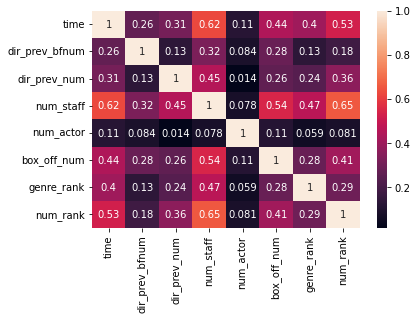

In [44]:
sns.heatmap(train.corr(), annot=True)

In [97]:
num=int(len(train.title))
num

600

In [101]:
from selenium.webdriver.common.alert import Alert
from selenium import webdriver  # 라이브러리(모듈) 가져오라
# pip install chromedriver_autoinstaller
from selenium.webdriver.common.keys import Keys
from selenium.webdriver import ActionChains as AC
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
import re
from time import sleep
import time

# 크롬 옵션
options = webdriver.ChromeOptions()  

# 크롬 윈도우 사이즈 조절
options.add_argument("--window-size=800,1200") # window-size -> 기본 : 1920,1080

import chromedriver_autoinstaller
chrome_path = chromedriver_autoinstaller.install()
driver = webdriver.Chrome(chrome_path, options=options)
time.sleep(3)
driver.get("https://www.naver.com")

# 네이버 검색어 입력 후 검색
element = driver.find_element_by_name("query")
element.clear()  # 혹시 검색창에 존재하는 텍스트 제거
for i in range(0, num):
    element.send_keys(train.title[i])  # 검색창에 검색어 전달
    element.submit()  # 검색 클릭
    time.sleep(1)
    main_c=driver.find_element_by_xpath(//*[@id="main_pack"]/div[2]/div[2]/div[2]/div/div[2]/div/div/ul/li[2]/div/div/strong/a)
    main_c.click()

SyntaxError: invalid syntax (Temp/ipykernel_32256/1194501863.py, line 31)

### 5가지 모델 사용
#### 1) GradientBoostingRegressor

In [47]:
gbm = GradientBoostingRegressor(random_state = 42)

In [46]:
rmse_list = []
gb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in gbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in gbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    gb_pred += (sub_pred / 10)

In [40]:
np.mean(rmse_list)

1174378.9765191542

***

#### 최종 예측 결과 블렌딩

In [41]:
submission['box_off_num'] = gb_pred 

In [42]:
submission.sort_values(by = 'box_off_num')

,title,box_off_num
130,댄서김의 은밀한 교수법,1.389427e+00
39,REC 알이씨,3.638057e+00
20,인플루언스,4.299066e+00
139,화려한 외출,4.970841e+00
234,슬픈남자,5.010369e+00
...,...,...
135,용의자,3.669326e+06
142,박수건달,3.995849e+06
61,수상한 고객들,4.491387e+06
179,군도: 민란의 시대,5.891882e+06


In [43]:
submission.to_csv("0203-gbr.csv", index = False)